# Random Walker Looper 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from perlin_noise import PerlinNoise

from IPython.display import display, Audio, HTML

In [2]:
noise = PerlinNoise(octaves=2)

In [3]:
n = 200

xs = np.zeros(n)
ys = np.zeros(n)
ts = np.linspace(0, 2*np.pi, n)

In [4]:
for i, t in enumerate(ts):
    xs[i] = 1.5*np.sin(t) + 1
    ys[i] = 1.618*np.cos(t) + 1

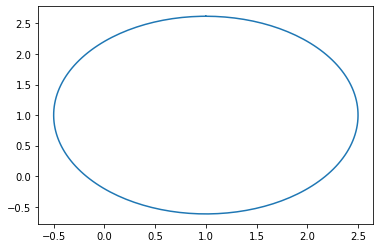

In [5]:
plt.plot(xs, ys)

In [6]:
z = [noise([x/10, y/10]) for x, y in zip(xs, ys)]

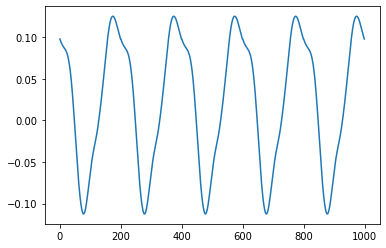

In [7]:
plt.plot(np.tile(z, 5))

In [8]:
def make_path(scale=10, offset=0.0, n=100):
    ts = np.linspace(0, 2*np.pi, n)
    
    st = np.sin(ts)
    ct = np.cos(ts)
    
    xx = st + offset
    xy = ct + offset
    
    yx = 1.618 * st + 10 + offset
    yy = 1.918 * ct + 10 + offset
    
    X = np.array([noise([x/scale, y/scale]) for x, y in zip(xx, xy)])
    Y = np.array([noise([x/scale, y/scale]) for x, y in zip(yx, yy)])
    
    # scale to [0, 1]
    X = (X - X.min()) / (X.max() - X.min())
    Y = (Y - Y.min()) / (Y.max() - Y.min())
    
    return X, Y

In [9]:
xs, ys = make_path(scale=8, offset=10, n=8)

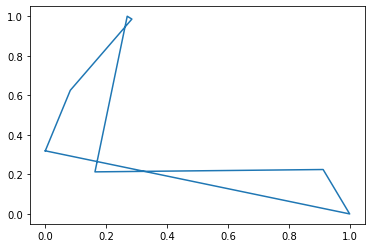

In [10]:
plt.plot(xs, ys)

plt.show()

## Make Audio Loop 

In [11]:
import json

In [12]:
from scipy.spatial import KDTree

In [43]:
with open('./data/lawki_now/reduced_points.json', 'r') as f:
    data = json.loads(f.read())

In [44]:
points = np.array(data['points'])

In [45]:
kd_tree = KDTree(points)

In [46]:
xs, ys = make_path(scale=8, offset=0.2, n=16)
path = np.array([xs, ys]).T

In [47]:
_, idxs = kd_tree.query(path)

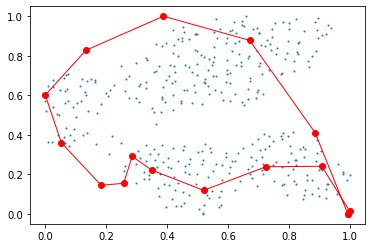

In [48]:
plt.scatter(points[:,0], points[:,1], s=1)
plt.plot(path[:, 0], path[:, 1], c='red', lw=1, marker='o')
plt.show()

In [19]:
idxs

array([ 74, 281, 159, 148,  49, 348, 265,  78, 283, 334, 270, 174, 193,
       326, 277,  74])

In [20]:
BPM = 80
sf = 44100
length = 60 / (BPM / 4)  # length in seconds of measure
grain_length = length / len(idxs)
grain_samples = int(grain_length * sf)

In [21]:
audio = np.zeros(int(length * sf))

In [22]:
import librosa

In [23]:
from tqdm.auto import tqdm

In [24]:
grouped = []
for i in idxs:
    if len(grouped) > 0 and grouped[-1][1] == i:
        grouped[-1][0] += 1
    else:
        grouped.append([1, i])

In [25]:
start = 0
for i in tqdm(grouped):
    fp = data['fps'][i[1]]
    y, _ = librosa.load(fp, sf)
    l = i[0] * grain_samples
    l = min(len(y), l)
    start += l
    audio[start:start+l] = y[:l]

  0%|          | 0/16 [00:00<?, ?it/s]

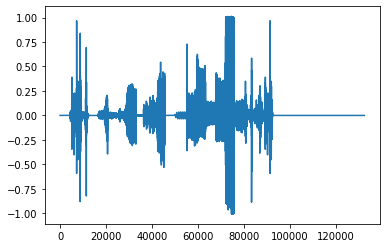

In [26]:
plt.plot(audio)

In [27]:
from IPython.display import display, Audio

In [28]:
display(Audio(np.tile(audio, 4), rate=sf))

In [29]:
audio_cache = dict()

In [30]:
def audio_from_path(path, bpm=80, sf=44100, extend=2):
    _, idxs = kd_tree.query(path)
    
    grouped = []
    for i in idxs:
        if len(grouped) > 0 and grouped[-1][1] == i:
            grouped[-1][0] += 1
        else:
            grouped.append([1, i])
    
    length = 60 / (bpm / 4)
    grain_length = length / len(idxs)
    grain_samples = int(grain_length * sf)
    
    audio = np.zeros(int(length * sf))
    
    start = 0
    for i in grouped:
        # load audio sample
        if i[1] in audio_cache:
            y = audio_cache[i[1]]
        else:
            fp = data['fps'][i[1]]
            y, _ = librosa.load(fp, sf)
            audio_cache[i[1]] = y
        
        # set length (in grains) of sample
        l1 = (i[0]) * grain_samples
        l2 = min(len(y), l1)
#         l3 = min(l2, max(0, len(audio) - start))
#         print(l1, l2, l3, start, len(audio))
        audio[start:start+l2] += y[:l2]
        start += l1
        
    return audio

In [31]:
xs, ys = make_path(scale=8, offset=0.0, n=16)
path = np.array([xs, ys]).T
audio = audio_from_path(path)

In [40]:
track = []

for offset in np.linspace(13, 13.2, 20):
#     print(f'{offset:.2f}')
    xs, ys = make_path(scale=8, offset=offset, n=16)
    path = np.array([xs, ys]).T
    
    audio = audio_from_path(path)
#     display(Audio(np.tile(audio, 4), rate=sf))
    track.append(audio)
    
track = np.concatenate(track)

In [41]:
Audio(track, rate=sf)

In [378]:
import soundfile

In [380]:
soundfile.write('./example_loop.wav', track, sf)

### Visualisations

In [34]:
from matplotlib.animation import FuncAnimation 

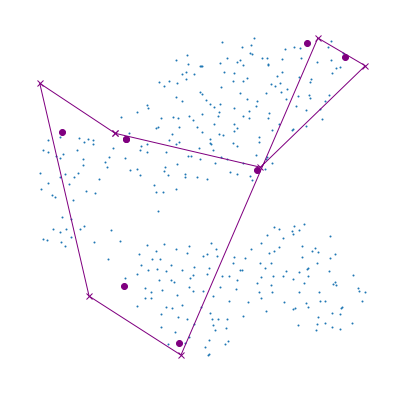

In [35]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
ax.set_axis_off()
ax.scatter(points[:,0], points[:,1], s=1)

loop, = ax.plot([], [], lw=1, marker='x', color='purple')
selected = ax.scatter([], [], marker='o', color='purple')

offsets = np.linspace(13, 15, 1000)


def animate(offset, fig, ax, selected):
    xs, ys = make_path(scale=8, offset=offset, n=8)
    path = np.array([xs, ys]).T
    _, idxs = kd_tree.query(path)
    
    selected.set_offsets(points[idxs])
    loop.set_data(path[:, 0], path[:, 1])
    
    return fig, ax
    
anim = FuncAnimation(fig, animate, frames=offsets, interval=20, blit=False, fargs=(fig, ax, selected))
plt.show()

In [36]:
HTML(anim.to_html5_video())

In [37]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [38]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    
    https://gist.github.com/pv/8036995
    
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def voronoi_polygons(points):
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    polygons = []
    for reg in regions:
        polygon = vertices[reg]
        polygons.append(polygon)
    return polygons

import random
def random_color(as_str=True, alpha=0.5):
    rgb = [random.randint(0,255),
           random.randint(0,255),
           random.randint(0,255)]
    if as_str:
        return "rgba"+str(tuple(rgb+[alpha]))
    else:
        # Normalize & listify
        return list(np.array(rgb)/255) + [alpha]
    
from matplotlib.patches import Polygon

def plot_polygons(polygons, ax=None, alpha=0.5, linewidth=0.7, saveas=None, show=True):
    # Configure plot 
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.subplot(111)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.axis("equal")

    # Set limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    # Add polygons 
    for poly in polygons:
        colored_cell = Polygon(poly,
                               linewidth=linewidth, 
                               alpha=alpha,
                               facecolor=random_color(as_str=False, alpha=1),
                               edgecolor="black")
        ax.add_patch(colored_cell)

    if not saveas is None:
        plt.savefig(saveas)
    if show:
        plt.show()

    return ax 

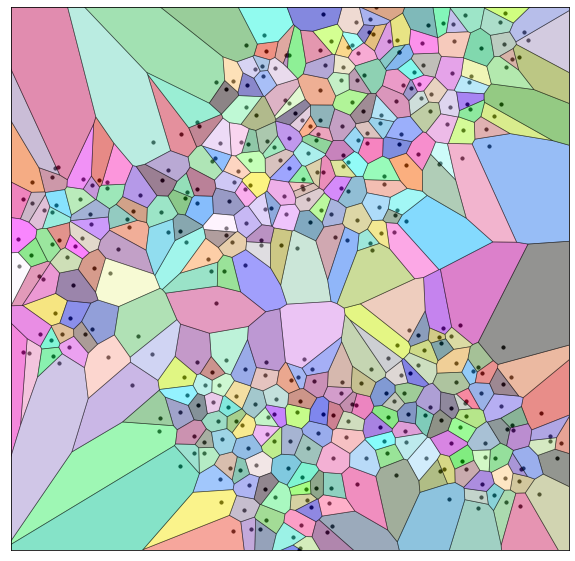

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
ax = plot_polygons(voronoi_polygons(points), show=False, ax=ax)
ax.scatter(points[:,0], points[:,1], s=10, c='k')
plt.show()